In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.io import loadmat 

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)

In [2]:
import networkx as nx

from scipy.stats import bernoulli
from scipy.special import loggamma

from sklearn.preprocessing import OneHotEncoder

import tqdm

from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

In [3]:
import os
import glob
import pickle

In [4]:
pd.options.display.max_rows = 1000

In [5]:
from functools import lru_cache

@lru_cache(maxsize = 10000)
def normterm_discrete(n, k):
    if n == 1:
        return np.log(k)
    if k == 1:
        return 1.0
    elif k == 2:
        return np.sum(sorted([ np.exp(loggamma(n+1) - loggamma(t+1) - loggamma(n-t+1) + 
                               t*(np.log(t) - np.log(n)) + (n-t)*(np.log(n-t) - np.log(n))
                        )
                        for t in range(1, n)]))
    else:
        return normterm_discrete(n, k-1) + n/(k-2) * normterm_discrete(n, k-2)

In [6]:
outdir = './output'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [7]:
cluster_range_max = 7

In [8]:
with open('n_emails.pkl', 'rb') as f:
    X_all = pickle.load(f)
    
X_all = np.array(X_all)

In [9]:
with open(os.path.join(outdir, 'pi_total_enron.pkl'), 'rb') as f:
    pi_all = pickle.load(f)
with open(os.path.join(outdir, 'theta_total_enron.pkl'), 'rb') as f:
    theta_all = pickle.load(f)
with open(os.path.join(outdir, 'z_total_enron.pkl'), 'rb') as f:
    z_all = pickle.load(f)

In [10]:
from itertools import permutations
import copy

h = 2
M = 1
#T = X_all.shape[2]
T = 157
K = 7

dnml_all = np.nan * np.ones((T, K))
dnml_f_all = np.nan * np.ones((T, K))
dnml_l_all = np.nan * np.ones((T, K))

nml_x_z_all = np.nan * np.ones((T, K))
nml_x_z_f_all = np.nan * np.ones((T, K))
nml_x_z_l_all = np.nan * np.ones((T, K))

nml_z_all = np.nan * np.ones((T, K))
nml_z_f_all = np.nan * np.ones((T, K))
nml_z_l_all = np.nan * np.ones((T, K))

for k in range(K):
    for t in range(h, T-3*h):
        X_t = X_all[:, :, t]

        nml_x_z_all_list = np.zeros(2*h)
        nml_z_all_list = np.zeros(2*h)
        for j, tau in enumerate(range(t-h+1, t+h+1)):
            z0 = np.argmax(z_all[tau][k], axis=1)
            n_k1_k2_p = np.array([ [[ np.sum(X_all[z0==k1, :, t0][:, z0==k2] == 1) for k2 in range(k+1)] for k1 in range(k+1)] \
                                   for t0 in range(t-h+1, t+h+1) ])
            n_k1_k2_n = np.array([ [[ np.sum(X_all[z0==k1, :, t0][:, z0==k2] == 0) for k2 in range(k+1)] for k1 in range(k+1)] \
                                   for t0 in range(t-h+1, t+h+1) ])
            n_k1_k2 = n_k1_k2_p + n_k1_k2_n
            phi_hat = np.sum(n_k1_k2_p, axis=0) / np.sum(n_k1_k2, axis=0)
            nml_x_z_all_list[j] = np.sum(-n_k1_k2_p * np.ma.log(phi_hat) - n_k1_k2_n * np.ma.log(1.0 - phi_hat) +
                                          np.array([[[ np.ma.log(normterm_discrete(n_k1_k2[i, k1, k2], 2)) \
                                               for k2 in range(k+1)] for k1 in range(k+1)] \
                                             for i, t0 in enumerate(range(t-h+1, t+h+1))]) )

            n_k = np.array([ np.sum(z0==kk) for kk in range(k+1)])
            pi_hat = n_k / np.sum(n_k)
            nml_z_all_list[j] = (np.sum( -n_k * np.ma.log(pi_hat)) + np.ma.log(normterm_discrete(100, k+1)) ) * 2 * h

        nml_x_z_all[t, k] = np.mean(nml_x_z_all_list)
        nml_z_all[t, k] = np.mean(nml_z_all_list)

        dnml_all[t, k] = nml_x_z_all[t, k] + nml_z_all[t, k]

        nml_x_z_f_all_list = np.zeros(h)
        nml_z_f_all_list = np.zeros(h)
        for j, tau in enumerate(range(t-h+1, t+1)):
            z1 = np.argmax(z_all[tau][k], axis=1)
            n_k1_k2_p = np.array([ [[ np.sum(X_all[z1==k1, :, t0][:, z1==k2] == 1) for k2 in range(k+1)] for k1 in range(k+1)] \
                                   for t0 in range(t-h+1, t+1) ])
            n_k1_k2_n = np.array([ [[ np.sum(X_all[z1==k1, :, t0][:, z1==k2] == 0) for k2 in range(k+1)] for k1 in range(k+1)] \
                                   for t0 in range(t-h+1, t+1) ])
            n_k1_k2 = n_k1_k2_p + n_k1_k2_n
            phi_hat = np.sum(n_k1_k2_p, axis=0) / np.sum(n_k1_k2, axis=0)
            phi_hat = phi_hat.reshape(1, phi_hat.shape[0], phi_hat.shape[1])

            nml_x_z_f_all_list[j] = np.sum(-n_k1_k2_p * np.ma.log(phi_hat) - n_k1_k2_n * np.ma.log(1.0 - phi_hat) + 
                                        np.array([[[ np.ma.log(normterm_discrete(n_k1_k2[i, k1, k2], 2)) \
                                              for k2 in range(k+1)] for k1 in range(k+1)] \
                                           for i, t0 in enumerate(range(t-h+1, t+1))])
                                    )

            n_k = np.array([ np.sum(z1==kk) for kk in range(k+1)])                
            pi_hat = n_k / np.sum(n_k)
            nml_z_f_all_list[j] = (np.sum(-n_k * np.ma.log(pi_hat) ) + np.ma.log(normterm_discrete(100, k+1)) ) * h

        nml_x_z_f_all[t, k] = np.mean(nml_x_z_f_all_list)
        nml_z_f_all[t, k] = np.mean(nml_z_f_all_list)

        dnml_f_all[t, k] = nml_x_z_f_all[t, k] + nml_z_f_all[t, k]

        nml_x_z_l_all_list = np.zeros(h)
        nml_z_l_all_list = np.zeros(h)
        for j, tau in enumerate(range(t+1, t+h+1)):
            z2 = np.argmax(z_all[tau][k], axis=1)
            n_k1_k2_p = np.array([ [[ np.sum(X_all[z2==k1, :, t0][:, z2==k2] == 1) for k2 in range(k+1)] for k1 in range(k+1)] \
                                  for t0 in range(t+1, t+h+1)])
            n_k1_k2_n = np.array([ [[ np.sum(X_all[z2==k1, :, t0][:, z2==k2] == 0) for k2 in range(k+1)] for k1 in range(k+1)] \
                                  for t0 in range(t+1, t+h+1)])
            n_k1_k2 = n_k1_k2_p + n_k1_k2_n

            phi_hat = np.sum(n_k1_k2_p, axis=0) / np.sum(n_k1_k2, axis=0)
            phi_hat = phi_hat.reshape(1, phi_hat.shape[0], phi_hat.shape[1])

            nml_x_z_l_all_list[j] = np.sum(-n_k1_k2_p * np.ma.log(phi_hat) - n_k1_k2_n * np.ma.log(1.0 - phi_hat) + \
                                        np.array([[[ np.ma.log(normterm_discrete(n_k1_k2[i, k1, k2], 2)) \
                                                    for k2 in range(k+1)] for k1 in range(k+1)] \
                                                  for i, t0 in enumerate(range(t+1, t+h+1))])
                                    )

            n_k = np.array([ np.sum(z2==kk) for kk in range(k+1)])
            pi_hat = n_k / np.sum(n_k)

            nml_z_l_all_list[j] = (np.sum(-n_k * np.ma.log(pi_hat) ) + np.ma.log(normterm_discrete(100, k+1)) ) * h

        nml_x_z_l_all[t, k] = np.mean(nml_x_z_l_all_list)
        nml_z_l_all[t, k] = np.mean(nml_z_l_all_list)

        dnml_l_all[t, k] = nml_x_z_l_all[t, k] + nml_z_l_all[t, k]

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Warning: converting a masked element to nan.
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Warning: converting a masked element to nan.
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Warning: converting a masked element to nan.
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Warning: converting a masked element to nan.
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Warning: converting a masked element to nan.
/Users/shi-

In [11]:
def calc_sc(X, Z1, Z2, K=3, L=3):    
    N = X.shape[0]
    
    sc_x_z = 0.0
    sc_z = 0.0

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                sc_x_z += np.log(normterm_discrete(n_all, 2))

    sc_z += np.log(normterm_discrete(N, K))
    
    return sc_x_z, sc_z

In [12]:
def calc_lsc(X, Z1, Z2, K=3, L=3):    
    codelen = 0.0
    N = X.shape[0]

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                codelen += n_all * np.log(n_all)
            
            if n_pos >=2:
                codelen -= n_pos * np.log(n_pos)
            if n_neg >=2:
                codelen -= n_neg * np.log(n_neg)

        n_k = np.sum(Z1 == k)
        if  n_k >= 1:
            codelen += n_k * (np.log(N) - np.log(n_k))

        codelen += (k + (k+1)*(k+2))/2 * np.log(N/(2.0*np.pi)) -(k+1)/2 * np.log(2.0) + \
           (k+1) * loggamma((k+3)/2) - loggamma((k+1)*(k+3)/2) + (k+1)*(k+2)/2 * np.log(np.pi)

    return codelen

In [13]:
def codelen_integer(k):
    codelen = np.log(2.865)
    while k >= 0.0:
        codelen += k
        k = np.log(k)
        
    return codelen

In [14]:
def calc_stats(X, z, scores, scores_f, scores_l, h, delta):
    scores = np.array(scores)
    scores_f = np.array(scores_f)
    scores_l = np.array(scores_l)
    
    K = scores.shape[1]
    T = scores.shape[0]
    
    codelens = np.array([ codelen_integer(k) for k in range(1, K+1)])
    
    idxes_all = np.argmin(scores + codelens, axis=1)
    
    models_estimated = np.zeros(T, dtype=np.int)
    models_former = np.zeros(T, dtype=np.int)
    models_latter = np.zeros(T, dtype=np.int)
    stats_complete = np.zeros(T)
    
    n_change = 0  # number of changes so far.
    for t in range(T):
        alpha= (n_change+1/2) / (t+1+1)
        m_estimated = idxes_all[t]

        # Lv.3 change (Model change)
        stats_half_t = np.zeros((cluster_range_max, cluster_range_max), dtype=np.float)
        for k1 in range(cluster_range_max):
            stats_former = scores_f[t, k1]
            for k2 in range(cluster_range_max):
                if k1 == k2:
                    p = 1.0 - alpha
                else:
                    p = alpha/(K-1)
                stats_latter = scores_l[t, k2]
                stats_half_t[k1, k2] = stats_former + stats_latter + codelens[k1] - np.log(p)
        m_former_estimated, m_latter_estimated = np.unravel_index(np.nanargmin(stats_half_t), (cluster_range_max, cluster_range_max))
        models_former[t] = m_former_estimated
        models_latter[t] = m_latter_estimated

        stat = 0.5 / h *(scores[t, m_estimated] + codelens[m_estimated] - stats_half_t[m_former_estimated, m_latter_estimated])
        stats_complete[t] = stat

        X_t = X[:, :, t]
        z_t = np.argmax(z[t][m_estimated], axis=1)
        sc_x_z, sc_z = calc_sc(X_t, z_t, m_estimated+1, m_estimated+1)
        thr_M = (sc_x_z + sc_z + codelens[m_estimated] - delta) / (2.0 * h)

        if (m_estimated == m_latter_estimated):
            # no model change happened
            model_t = m_estimated
        else:
            model_t = m_latter_estimated

        if t >= 1:
            model_prev = models_estimated[t-1]
            if model_t != model_prev:
                n_change += 1            
        models_estimated[t] = model_t
    
    stats_complete = np.hstack(([np.nan]*2*h, stats_complete))

    return stats_complete, models_estimated, models_former, models_latter

In [15]:
def calc_stats_with_modelidx(scores, scores_f, scores_l, idxes_model, idxes_model_f, idxes_model_l, h):
    scores = np.array(scores)
    scores_f = np.array(scores_f)
    scores_l = np.array(scores_l)
    
    stats_complete = np.zeros(idxes_model.shape[0], dtype=np.float)
    for t in range(idxes_model.shape[0]):
        stat = 0.5/h * (scores[t, idxes_model[t]] - \
                        scores_f[t, idxes_model_f[t]] - \
                        scores_l[t, idxes_model_l[t]])
        stats_complete[t] = stat
            
    stats_complete = np.hstack(([np.nan]*2*h, stats_complete))
            
    return stats_complete

In [16]:
delta = 0.01
T = 153

dnml, models_estimated, models_former, models_latter = calc_stats(
    X_all, z_all, dnml_all[h:(T-h), :], dnml_f_all[h:(T-h), :], dnml_l_all[h:(T-h), :], h, delta=delta)

nml_x_z = calc_stats_with_modelidx(nml_x_z_all[h:(T-h), :], nml_x_z_f_all[h:(T-h), :], nml_x_z_l_all[h:(T-h), :], 
                                   models_estimated, models_former, models_latter, h)
 
nml_z = calc_stats_with_modelidx(nml_z_all[h:(T-h), :], nml_z_f_all[h:(T-h), :], nml_z_l_all[h:(T-h), :], 
                                 models_estimated, models_former, models_latter, h)

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [17]:
dnml.shape

(153,)

In [18]:
dnml_df = pd.DataFrame(dnml.reshape(1, -1), columns=np.arange(1, T+1).astype(str)).reset_index()
nml_x_z_df = pd.DataFrame(nml_x_z.reshape(1, -1), columns=np.arange(1, T+1).astype(str)).reset_index()
nml_z_df = pd.DataFrame(nml_z.reshape(1, -1), columns=np.arange(1, T+1).astype(str)).reset_index()

In [19]:
dnml_df_melt = dnml_df.melt(id_vars='index')
dnml_df_melt['variable'] = dnml_df_melt['variable'].astype(int)

nml_x_z_df_melt = nml_x_z_df.melt(id_vars='index')
nml_x_z_df_melt['variable'] = nml_x_z_df_melt['variable'].astype(int)

nml_z_df_melt = nml_z_df.melt(id_vars='index')
nml_z_df_melt['variable'] = nml_z_df_melt['variable'].astype(int)

In [20]:
dnml_df_melt['criterion'] = 'DNML'
nml_x_z_df_melt['criterion'] = 'NML (X|Z)'
nml_z_df_melt['criterion'] = 'NML (Z)'

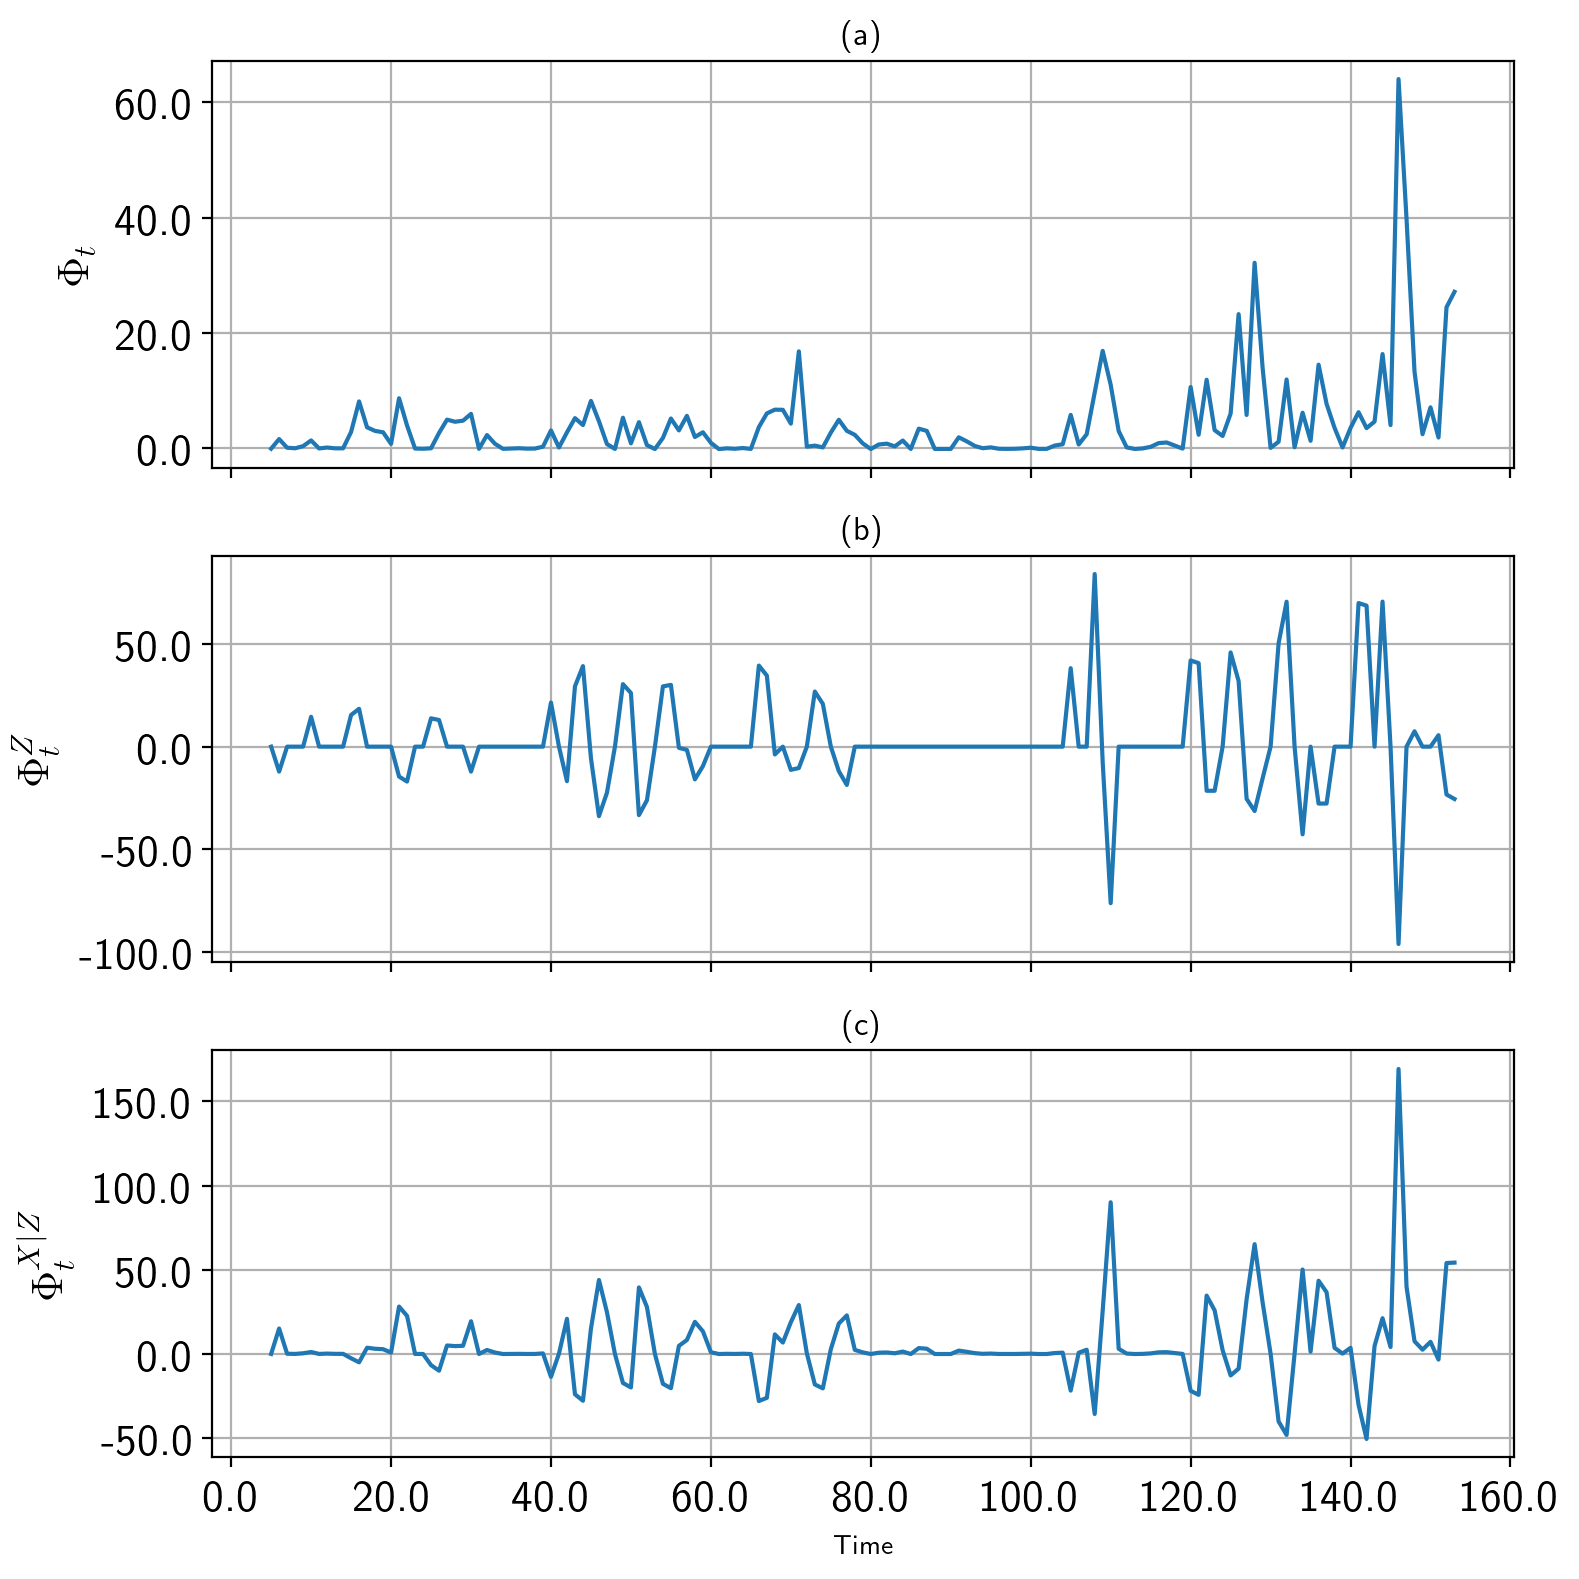

In [21]:
fontsize_title = 18
fontsize = 16

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 8), dpi=200)

sns.lineplot(x='variable', y='value', data=dnml_df_melt, ax=axes[0])
axes[0].grid()
axes[0].set_title('(a)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel(r'$\Phi_{t}$', fontsize=fontsize)

sns.lineplot(x='variable', y='value', data=nml_z_df_melt, ax=axes[1])
axes[1].grid()
axes[1].set_title('(b)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel(r'$\Phi_{t}^{Z}$', fontsize=fontsize)

sns.lineplot(x='variable', y='value', data=nml_x_z_df_melt, ax=axes[2])
axes[2].grid()
axes[2].set_title('(c)')
axes[2].set_xlabel('Time')
axes[2].set_ylabel(r'$\Phi_{t}^{X|Z}$', fontsize=fontsize)

for ax in axes:
    fontProperties = {'family':'sans-serif', 'weight': 'normal', 'size': fontsize}
    ax.set_xticklabels(ax.get_xticks(), fontProperties)
    ax.set_yticklabels(ax.get_yticks(), fontProperties)

fig.tight_layout()

plt.show()